# Keras 除錯技巧

## 程式參考來源：
- https://keras.io/examples/keras_recipes/debugging_tips/

## model.summary() 顯示 Model output

In [2]:
import tensorflow as tf
from tensorflow.keras import layers

# 輸入的維度
input_shape = (28, 28, 1)

# 建立模型
model_cnn = tf.keras.Sequential(
    [
        tf.keras.Input(shape=input_shape),
        layers.Conv2D(32, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(10, activation="softmax"),
    ]
)

# 顯示 Model output
model_cnn.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                1

## 較複雜的神經網路

In [4]:
from tensorflow import keras

num_tags = 12  # Number of unique issue tags
num_words = 10000  # Size of vocabulary obtained when preprocessing text data
num_departments = 4  # Number of departments for predictions

title_input = keras.Input(
    shape=(None,), name="title"
)  # Variable-length sequence of ints
body_input = keras.Input(shape=(None,), name="body")  # Variable-length sequence of ints
tags_input = keras.Input(
    shape=(num_tags,), name="tags"
)  # Binary vectors of size `num_tags`

# Embed each word in the title into a 64-dimensional vector
title_features = layers.Embedding(num_words, 64)(title_input)
# Embed each word in the text into a 64-dimensional vector
body_features = layers.Embedding(num_words, 64)(body_input)

# Reduce sequence of embedded words in the title into a single 128-dimensional vector
title_features = layers.LSTM(128)(title_features)
# Reduce sequence of embedded words in the body into a single 32-dimensional vector
body_features = layers.LSTM(32)(body_features)

# Merge all available features into a single large vector via concatenation
x = layers.concatenate([title_features, body_features, tags_input])

# Stick a logistic regression for priority prediction on top of the features
priority_pred = layers.Dense(1, name="priority")(x)
# Stick a department classifier on top of the features
department_pred = layers.Dense(num_departments, name="department")(x)

# Instantiate an end-to-end model predicting both priority and department
model = keras.Model(
    inputs=[title_input, body_input, tags_input],
    outputs=[priority_pred, department_pred],
)


# 顯示 Model output
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
title (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
body (InputLayer)               [(None, None)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 64)     640000      title[0][0]                      
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 64)     640000      body[0][0]                       
_______________________________________________________________________________________

## 繪製模型圖

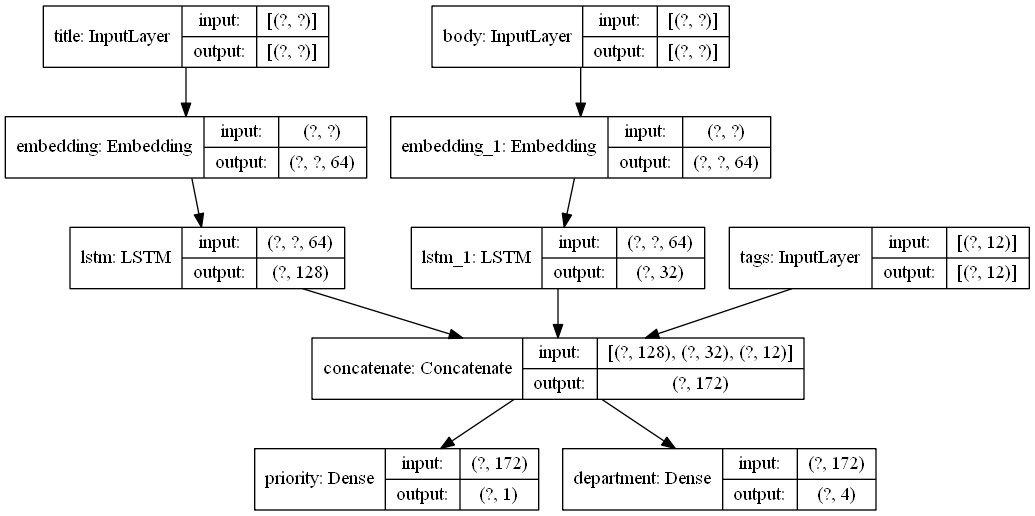

In [6]:
keras.utils.plot_model(model, show_shapes=True, to_file='debug_model.png')

## 以CNN辨識手寫阿拉伯數字(MNIST)

In [3]:
import tensorflow as tf
import numpy as np

mnist = tf.keras.datasets.mnist
# 匯入 MNIST 手寫阿拉伯數字 訓練資料
(x_train, y_train),(x_test, y_test) = mnist.load_data()

x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)

# 特徵縮放，使用常態化(Normalization)，公式 = (x - min) / (max - min)
# 顏色範圍：0~255，所以，公式簡化為 x / 255
# 注意，顏色0為白色，與RGB顏色不同，(0,0,0) 為黑色。
x_train_norm, x_test_norm = x_train / 255.0, x_test / 255.0


# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model_cnn.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 訓練
model_cnn.fit(x_train_norm, y_train, epochs=5, validation_split=0.2)


Epoch 1/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2341 - accuracy: 0.9290 - val_loss: 0.0690 - val_accuracy: 0.9801
Epoch 2/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0886 - accuracy: 0.9726 - val_loss: 0.0577 - val_accuracy: 0.9823
Epoch 3/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0674 - accuracy: 0.9789 - val_loss: 0.0456 - val_accuracy: 0.9867
Epoch 4/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0569 - accuracy: 0.9833 - val_loss: 0.0383 - val_accuracy: 0.9890
Epoch 5/5
1500/1500 [==============================] - 5s 3ms/step - loss: 0.0498 - accuracy: 0.9843 - val_loss: 0.0377 - val_accuracy: 0.9887


## 顯示各層的權重值

In [32]:
print(model_cnn.layers[-1].weights)

[<tf.Variable 'dense_3/kernel:0' shape=(1600, 10) dtype=float32, numpy=
array([[-0.0605713 ,  0.04136651, -0.02466299, ..., -0.02221905,
         0.03800451, -0.06599013],
       [-0.13269557,  0.15831184, -0.03530624, ..., -0.17652085,
         0.12585746,  0.11422092],
       [-0.00621057,  0.13934352, -0.13450716, ...,  0.13790897,
         0.05315162, -0.2292541 ],
       ...,
       [ 0.02627586, -0.1448069 , -0.01264584, ...,  0.02807761,
         0.02270174, -0.08306412],
       [ 0.10848077,  0.02394478,  0.08711048, ...,  0.04476574,
        -0.12270474, -0.02363132],
       [-0.13488628,  0.0221121 ,  0.13257587, ..., -0.0839394 ,
        -0.10995742,  0.03407198]], dtype=float32)>, <tf.Variable 'dense_3/bias:0' shape=(10,) dtype=float32, numpy=
array([ 0.03607793,  0.16976619,  0.00333053, -0.0231845 , -0.09599205,
       -0.03199821, -0.03972061,  0.0194642 , -0.00916587,  0.00491514],
      dtype=float32)>]


## 顯示各層的 output 值

In [6]:
from tensorflow import keras
from tensorflow.keras import layers

# 輸入的維度
input_shape = (28, 28, 1)

# 建立模型
model = tf.keras.Sequential([
    tf.keras.Input(shape=input_shape),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.MaxPooling2D(2),
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(32, 3, activation='relu'),
    layers.GlobalMaxPooling2D(),
    layers.Dense(10),
])
extractor = keras.Model(inputs=model.inputs,
                        outputs=[layer.output for layer in model.layers])
features = extractor(x_test[0:1])
features

[<tf.Tensor: shape=(1, 26, 26, 32), dtype=float32, numpy=
 array([[[[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          ...,
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.]],
 
         ...,
 
         [[0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          [0., 0., 0., ..., 0., 0., 0.],
          .

## 顯示倒數第2層的 output 值

In [7]:
intermediate_layer_model = keras.Model(inputs=model.input,
                                       outputs=model.layers[-2].output)
features = intermediate_layer_model(x_test[0:1])
features

<tf.Tensor: shape=(1, 32), dtype=float32, numpy=
array([[ 2.361034 ,  0.       , 11.826235 , 11.905228 , 11.809198 ,
         4.529831 , 11.46335  , 17.169445 , 14.374775 , 20.136877 ,
        15.372832 , 19.519123 , 16.784405 ,  2.8410788, 13.812962 ,
        16.398233 , 16.819395 , 11.324921 ,  5.221665 , 14.742571 ,
         8.214535 , 12.635227 , 16.941227 , 16.357212 , 12.619803 ,
         4.315529 ,  2.1703131, 20.838778 , 14.466827 ,  2.0255375,
         4.690336 ,  9.050381 ]], dtype=float32)>

## 自訂層除錯

In [8]:
import tensorflow as tf
from tensorflow.keras import layers


class MyAntirectifier(layers.Layer):
    def build(self, input_shape):
        output_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(output_dim * 2, output_dim),
            initializer="he_normal",
            name="kernel",
            trainable=True,
        )

    def call(self, inputs):
        # Take the positive part of the input
        pos = tf.nn.relu(inputs)
        # Take the negative part of the input
        neg = tf.nn.relu(-inputs)
        # Concatenate the positive and negative parts
        # ****** bug, axis應該為1 ******* #
        concatenated = tf.concat([pos, neg], axis=0)
        # Project the concatenation down to the same dimensionality as the input
        return tf.matmul(concatenated, self.kernel)

## 測試

In [9]:
x = tf.random.normal(shape=(2, 5))
y = MyAntirectifier()(x)

InvalidArgumentError: Matrix size-incompatible: In[0]: [4,5], In[1]: [10,5] [Op:MatMul]

## 加上debug訊息

In [3]:
class MyAntirectifier(layers.Layer):
    def build(self, input_shape):
        output_dim = input_shape[-1]
        self.kernel = self.add_weight(
            shape=(output_dim * 2, output_dim),
            initializer="he_normal",
            name="kernel",
            trainable=True,
        )

    def call(self, inputs):
        pos = tf.nn.relu(inputs)
        neg = tf.nn.relu(-inputs)
        print("pos.shape:", pos.shape)
        print("neg.shape:", neg.shape)
        concatenated = tf.concat([pos, neg], axis=1)
        print("concatenated.shape:", concatenated.shape)
        print("kernel.shape:", self.kernel.shape)
        return tf.matmul(concatenated, self.kernel)


## 測試

In [4]:
x = tf.random.normal(shape=(2, 5))
y = MyAntirectifier()(x)

pos.shape: (2, 5)
neg.shape: (2, 5)
concatenated.shape: (2, 10)
kernel.shape: (10, 5)
